# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 1.0 Analysis Setup

In [1]:
#import all libraries
import pandas as pd
import numpy as np
import math
import json
import datetime
import pickle
from sklearn.preprocessing import MultiLabelBinarizer # for one hot encoding
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import pylab as pl
import seaborn as sns
import math
% matplotlib inline

In [2]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2. Data cleaning, data transformation and Feature extraction

**Portfolio Dataset**

In [104]:
portfolio.head()


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [105]:
portfolio.shape

(10, 6)

In [106]:
# total count of missing values 
print(portfolio.isnull().sum().sum())
#no missing values

0


In [34]:
#check for total type of offers
portfolio['id'].nunique()
#Total 10 offer ids in circulation

10

In [107]:
#check for duplicate rows
portfolio[portfolio.duplicated(['id'], keep=False)]

,channels,difficulty,duration,id,offer_type,reward


In [108]:
def portfolio_transform(portfolio):
    '''
    Transforming the portfolio dataframe into the required format for our modelling and analysis
    
    INPUT:
    portfolio - the portfolio dataframe to be transformed
    
    OUTPUT:
    portfolio_df - the transformed portfolio dataframe
    
    '''
    # change the duration from day to hour
    portfolio_df = portfolio.copy()
    portfolio_df['duration'] = portfolio_df['duration'] * 24
    
    # apply one hot encoding to channels column
    mlb = MultiLabelBinarizer()
    portfolio_df = portfolio_df.join(pd.DataFrame(mlb.fit_transform(portfolio_df.pop('channels')),
                          columns=mlb.classes_,
                          index=portfolio_df.index))
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(portfolio_df['offer_type'])
    
    # drop the offer_type column
    portfolio_df.drop(['offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    portfolio_df = pd.concat([portfolio_df, offer_type], axis=1, sort=False)
    
    return portfolio_df

In [109]:
portfolio_df = portfolio_transform(portfolio)
portfolio_df.head()

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


**Profile Dataset**

In [101]:
profile.head()

,age,gender,id,income,member_since_days
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1325
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1392
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,1040
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,1116
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1206


In [16]:
profile.shape

(17000, 5)

In [17]:
# total count of missing values 
print(profile.isnull().sum().sum())


4350


No missing values in profile dataset

In [4]:
#missing values by column
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Missing values in the gender and income column

In [10]:
#check for duplicate Customers
profile['id'].nunique()
#no duplicates found

17000

In [ ]:
def profile_transform(profile):
    '''
    Transforming the profile dataframe into the required format for our modelling and analysis
    
    INPUT:
    profile - the portfolio dataframe to be transformed
    
    OUTPUT:
    profile - the transformed profile dataframe
    
    '''  
    # drop all missing values since its only a small subset of dataset
    profile.dropna(inplace=True)
    
    # feature extraction the number of days since the user is a member of starbucks
    profile['member_since_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['member_since_days'] = profile['member_since_days'].dt.days
     # drop the became_member_on column
    profile.drop(['became_member_on'], axis=1, inplace=True)
   
    return profile

In [110]:
profile_df = profile_transform(profile)
profile_df.head()

,age,gender,id,income,member_since_days
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1325
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1392
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,1040
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,1116
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1206


In [111]:
profile_df.describe()

,age,income,member_since_days
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1471.478988
std,17.383705,21598.299410,419.205158
min,18.000000,30000.000000,949.000000
25%,42.000000,49000.000000,1157.000000
50%,55.000000,64000.000000,1307.000000
75%,66.000000,80000.000000,1746.000000
max,101.000000,120000.000000,2772.000000


**Transcript Dataset**

In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.shape

(306534, 4)

In [9]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [13]:
#Check missing values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [14]:
# explore the transcript records for one user
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [11]:
def transcript_transform(transcript):
    '''
    Transforming the profile dataframe into the required format for our modelling and analysis
    
    INPUT:
    transcript - the transcript dataframe to be transformed
    
    OUTPUT:
    transcript - the transformed transcript dataframe
     
    '''
    # extract the rows that are related to offer action (e.g. 'offer received', 'offer viewed', 'offer completed')
    list_of_values = ['offer received', 'offer viewed', 'offer completed']

    transcript =  transcript[transcript['event'].isin(list_of_values)]

    # extract the offer id from value column
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id']
    
     # drop the value column
    transcript.drop(['value'], axis=1, inplace=True)
    
    return transcript

In [12]:
transcript_df = transcript_transform(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
transcript_df.head()

,event,person,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [13]:
transcript_df.describe()

,time
count,167581.000000
mean,353.778412
std,198.301287
min,0.000000
25%,168.000000
50%,408.000000
75%,510.000000
max,714.000000


## 3. Exploratory Data Analysis

**Profile Dataset**

Text(0.5,0.98,'Histogram of all numerical variables in profile dataset')

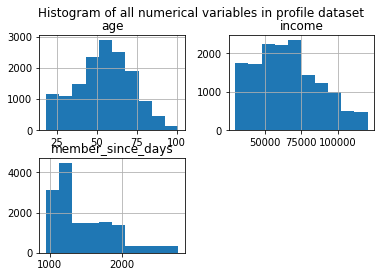

In [59]:
#Make histogram of all numerical variables
axes = profile_df.hist()
pl.suptitle("Histogram of all numerical variables in profile dataset")

The distributions shows the following three things about our customer profile
* Most customers are in the middle to older age range
* Annual income of Starbucks customers is majorly ≤$100000
* Most customers take >1000 and <1250 days before they become a member

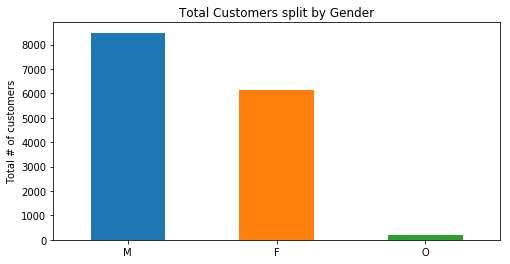

In [84]:
#plotting gender distribution 
fig, ax = plt.subplots(figsize = (8,4))
profile_df.gender.value_counts().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Total Customers split by Gender')
ax.set_ylabel('Total # of customers')
plt.show ()

The dataset contains higher percentage of Male customers as opposed to female/other.

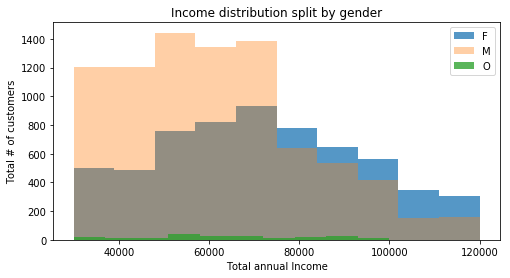

In [86]:
# plot income distribution histogram
fig, ax = plt.subplots(figsize = (8,4))

ax.hist(profile_df[profile_df.gender == 'F']['income'], alpha=0.76, label='F')
ax.hist(profile_df[profile_df.gender == 'M']['income'], alpha=0.37, label='M')
ax.hist(profile_df[profile_df.gender == 'O']['income'], alpha=0.78, label='O')
ax.set_xlabel('Total annual Income')
ax.set_ylabel('Total # of customers')
ax.set_title('Income distribution split by gender')
ax.legend()
plt.show ()

Male customers have have a left skewed income distribution of <=$80000 whereas female customer's income seems to normally distributed across the range

**Portfolio Dataset**

Text(0.5,0.98,'Histogram of all numerical variables in portfolio dataset')

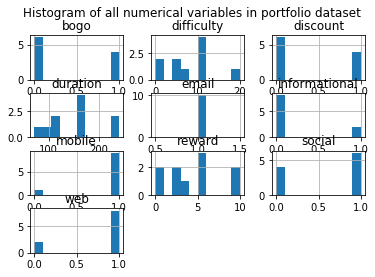

In [33]:
#Make histogram of all numerical variables
axes = portfolio_df.hist()
pl.suptitle("Histogram of all numerical variables in portfolio dataset")

This view is not highly insightful, however we can see that difficulty of 10 and reward of 5 seems to be the most commonly occuring ones in the offers

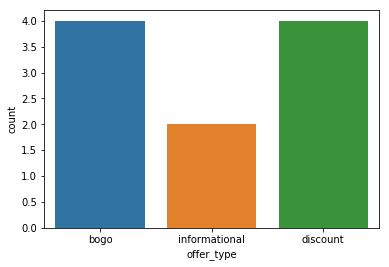

In [114]:
#checking distribution of events in the dataframe
sns.countplot('offer_type', data= portfolio)

Offer types are dominated by BOGO and discount.

**Transcript dataset**

Text(0.5,0.98,'Histogram of all numerical variables in transcript dataset')

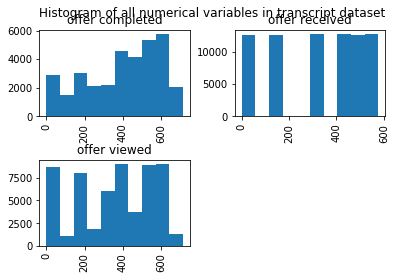

In [37]:
#Make histogram of all numerical variables
axes = transcript_df['time'].hist(by=transcript_df['event'])
pl.suptitle("Histogram of all numerical variables in transcript dataset")

Based on the above charts we can see that there are specific times in which offers are recieved i.e. Starbucks sends out these offers at once to all relevant customers. However, there is so specific time when the offers maybe viewed and completed as expected.

Text(0.5,0.98,'Histogram of all numerical variables in transcript dataset')

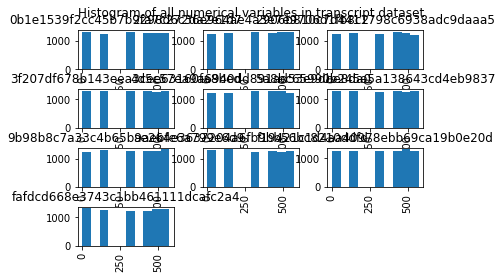

In [40]:
axes = transcript_df['time'].hist(by=transcript_df[transcript_df['event']=='offer received']['offer_id'])
pl.suptitle("Histogram of time when a specfic type of offer is sent out")

As is expected there isnt a specific time for any particular type of offer to be sent out.

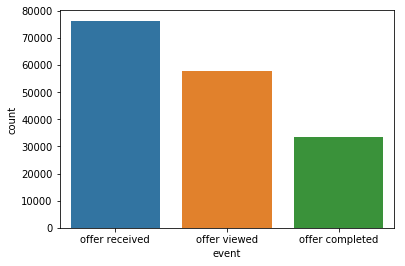

In [90]:
#checking distribution of events in the dataframe
sns.countplot('event', data= transcript_df)

The offer recieved,viewed and completed follow the expected trend i.e more offers are sent out than will be viewed or completed.

## 4. Data modelling

In order to build a recomendation engine, we can use FunkSVD algorithm. The dataset needs to be in user-item matrix format for that purposes. Following functions will help further transform the datasets

In [53]:
def create_user_item_matrix(offers_given, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offers_given.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # Retaining only bogo and discount offers first and dropping all else for simplicity
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Processing Offer: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 5000 == 0:
                print("finished upto #:", num, 'persons')
            events = []
            for event in offers_given[(offers_given['offer_id']==offer_id) & (offers_given['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check that transaction sequence is offer received -> offer viewed -> offer completed
                    # Only if its in that order we assume the offer was successfully accepted
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix


In [19]:
#create User item matrix of customers and offers they accept
all_df = create_user_item_matrix(transcript_df, 'user_item_matrix.p')

Processing Offer:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  2906b810c7d4411798c6938adc9daaa5
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  4d5c57ea9a6940dd891ad53e9dbe8da0
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  9b98b8c7a33c4b65b9aebfe6a799e6d9
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  ae264e3637204a6fb9bb56bc8210ddfd
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  f19421c1d4aa40978ebb69ca19b0e20d
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 

In [20]:
all_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [55]:
#Function to split dataset in training and testing subsets
def user_item_train_test_split (transcript_df, training_perc=0.7):
    """Function that prepares train and test user_item_matrices out of transcript dataset.
    
    INPUT: 
    1.  dataframe to split into training and testing datasets
    2.  training dataset size percentage, default = 0.7

    OUTPUT:
    1.  train dataframe
    2.  test dataframe
    3.  train user_item_matrix
    4.  test user_item_matrix
        
    """
    
     #saving a dataframe copy to work with
    transcript_dfcopy = transcript_df.copy()
    
    training_size= math.ceil(transcript_dfcopy.shape[0]*training_perc)
    testing_size= transcript_dfcopy.shape[0]-training_size
    
    training_df = transcript_dfcopy.head(training_size)
    test_df = transcript_dfcopy.iloc[training_size:training_size+testing_size]
       
    #converting both into user_item_matrix format
    print('Preparing Training matrix')
    train_matrix = create_user_item_matrix(training_df, 'train_df.p')
    print('Preparing Testing matrix')
    test_matrix = create_user_item_matrix(test_df, 'test_df.p')
    
    return training_df,test_df,train_matrix, test_matrix  

In [56]:
training_df,test_df,train_matrix, test_matrix  =user_item_train_test_split(transcript_df)

Preparing Training matrix
Processing Offer:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  2906b810c7d4411798c6938adc9daaa5
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  4d5c57ea9a6940dd891ad53e9dbe8da0
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  9b98b8c7a33c4b65b9aebfe6a799e6d9
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  ae264e3637204a6fb9bb56bc8210ddfd
finished upto #: 5000 persons
finished upto #: 10000 persons
finished upto #: 15000 persons
Processing Offer:  f19421c1d4aa40978ebb69ca19b0e20d
finished upto #: 5000 persons
finished upto #: 10000 perso

In [57]:
train_matrix.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [14]:
# Data checkpoint to read user matrices when needed 
# all_df = pd.read_pickle('user_item_matrix.p')
# train_matrix = pd.read_pickle('train_df.p')
# test_matrix = pd.read_pickle('train_df.p')

In [58]:
#Function implementing FunkSVD
def FunkSVD(user_item_matrix, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    user_mat - (numpy array) a matrix with users as rows, offers as columns, and completion as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = user_item_matrix.shape[0]
    n_offers = user_item_matrix.shape[1]
    num_offers = np.count_nonzero(~np.isnan(user_item_matrix))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the offer was completed
                if user_item_matrix[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = user_item_matrix[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results for iteration
        print("%d \t\t %f" % (iteration+1, sse_accum / num_offers))
        
    return user_mat, offer_mat 

In [59]:
#create numpy array of training matrix
np_train=np.matrix(train_matrix)

In [60]:
# Fit FunkSVD with the specified hyper parameters to the training data
user_mat_20, offer_mat_20 = FunkSVD(np_train, latent_features=20, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.079313
2 		 0.029744
3 		 0.028501
4 		 0.028176
5 		 0.027991
6 		 0.027834
7 		 0.027686
8 		 0.027540
9 		 0.027395
10 		 0.027252
11 		 0.027109
12 		 0.026968
13 		 0.026827
14 		 0.026687
15 		 0.026548
16 		 0.026410
17 		 0.026273
18 		 0.026137
19 		 0.026001
20 		 0.025867
21 		 0.025733
22 		 0.025600
23 		 0.025468
24 		 0.025336
25 		 0.025206
26 		 0.025076
27 		 0.024947
28 		 0.024819
29 		 0.024692
30 		 0.024565
31 		 0.024439
32 		 0.024314
33 		 0.024190
34 		 0.024066
35 		 0.023943
36 		 0.023821
37 		 0.023700
38 		 0.023579
39 		 0.023459
40 		 0.023340
41 		 0.023221
42 		 0.023103
43 		 0.022986
44 		 0.022869
45 		 0.022754
46 		 0.022638
47 		 0.022524
48 		 0.022410
49 		 0.022297
50 		 0.022184
51 		 0.022072
52 		 0.021961
53 		 0.021851
54 		 0.021740
55 		 0.021631
56 		 0.021522
57 		 0.021414
58 		 0.021307
59 		 0.021200
60 		 0.021093
61 		 0.020987
62 		 0.020882
63 		 0.020777
64 		 0

In [61]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_15, offer_mat_15 = FunkSVD(np_train, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.061120
2 		 0.031322
3 		 0.030512
4 		 0.030224
5 		 0.029999
6 		 0.029786
7 		 0.029576
8 		 0.029369
9 		 0.029164
10 		 0.028961
11 		 0.028759
12 		 0.028560
13 		 0.028362
14 		 0.028166
15 		 0.027972
16 		 0.027779
17 		 0.027589
18 		 0.027400
19 		 0.027212
20 		 0.027027
21 		 0.026843
22 		 0.026661
23 		 0.026480
24 		 0.026301
25 		 0.026124
26 		 0.025948
27 		 0.025774
28 		 0.025602
29 		 0.025431
30 		 0.025261
31 		 0.025093
32 		 0.024927
33 		 0.024761
34 		 0.024598
35 		 0.024436
36 		 0.024275
37 		 0.024116
38 		 0.023958
39 		 0.023801
40 		 0.023646
41 		 0.023493
42 		 0.023340
43 		 0.023189
44 		 0.023039
45 		 0.022891
46 		 0.022744
47 		 0.022598
48 		 0.022453
49 		 0.022310
50 		 0.022168
51 		 0.022027
52 		 0.021887
53 		 0.021748
54 		 0.021611
55 		 0.021475
56 		 0.021340
57 		 0.021206
58 		 0.021073
59 		 0.020942
60 		 0.020811
61 		 0.020682
62 		 0.020553
63 		 0.020426
64 		 0

In [62]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(np_train, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.050931
2 		 0.034200
3 		 0.033361
4 		 0.032943
5 		 0.032580
6 		 0.032229
7 		 0.031885
8 		 0.031547
9 		 0.031213
10 		 0.030884
11 		 0.030560
12 		 0.030240
13 		 0.029924
14 		 0.029613
15 		 0.029307
16 		 0.029004
17 		 0.028706
18 		 0.028412
19 		 0.028123
20 		 0.027837
21 		 0.027555
22 		 0.027277
23 		 0.027003
24 		 0.026733
25 		 0.026466
26 		 0.026203
27 		 0.025944
28 		 0.025688
29 		 0.025436
30 		 0.025188
31 		 0.024942
32 		 0.024700
33 		 0.024462
34 		 0.024227
35 		 0.023995
36 		 0.023766
37 		 0.023540
38 		 0.023317
39 		 0.023097
40 		 0.022881
41 		 0.022667
42 		 0.022456
43 		 0.022248
44 		 0.022043
45 		 0.021840
46 		 0.021641
47 		 0.021444
48 		 0.021249
49 		 0.021057
50 		 0.020868
51 		 0.020681
52 		 0.020497
53 		 0.020315
54 		 0.020136
55 		 0.019959
56 		 0.019784
57 		 0.019612
58 		 0.019442
59 		 0.019274
60 		 0.019108
61 		 0.018945
62 		 0.018783
63 		 0.018624
64 		 0

In [63]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(np_train, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.050672
2 		 0.045327
3 		 0.044160
4 		 0.043192
5 		 0.042267
6 		 0.041368
7 		 0.040492
8 		 0.039640
9 		 0.038810
10 		 0.038002
11 		 0.037216
12 		 0.036450
13 		 0.035705
14 		 0.034979
15 		 0.034272
16 		 0.033584
17 		 0.032915
18 		 0.032262
19 		 0.031627
20 		 0.031009
21 		 0.030407
22 		 0.029821
23 		 0.029250
24 		 0.028694
25 		 0.028153
26 		 0.027625
27 		 0.027112
28 		 0.026612
29 		 0.026125
30 		 0.025650
31 		 0.025188
32 		 0.024737
33 		 0.024298
34 		 0.023871
35 		 0.023454
36 		 0.023048
37 		 0.022653
38 		 0.022267
39 		 0.021892
40 		 0.021525
41 		 0.021168
42 		 0.020820
43 		 0.020481
44 		 0.020150
45 		 0.019828
46 		 0.019514
47 		 0.019207
48 		 0.018908
49 		 0.018616
50 		 0.018332
51 		 0.018054
52 		 0.017784
53 		 0.017519
54 		 0.017262
55 		 0.017010
56 		 0.016765
57 		 0.016526
58 		 0.016292
59 		 0.016064
60 		 0.015841
61 		 0.015624
62 		 0.015412
63 		 0.015205
64 		 0

Based on the MSE value the model with 5 latent featues seems to be performing the best.
However, that could be a case of overfitting.Therefore we will validate our results by making predictions on the test dataset.

**Check performance of the FUNKSVD models with the various number of latent features against the test dataset**

In [77]:
#Predict reaction function
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offer df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_matrix.index)
        offer_ids_series = np.array(train_matrix.columns)

        # User row and offer Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])

        return pred
    
    except:
        return None

In [78]:
#Generate validation score function
def validation_score(test_matrix, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_matrix))
    
    sse_accum = 0
    
    for user_id in test_matrix.index:
        for offer_id in test_matrix.columns:
            if ~np.isnan(test_matrix.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_matrix.loc[user_id, offer_id] - predict_value #predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print('Validation score: ',sse_accum / num_complete)

In [79]:
# Evaluation for latent features of 20
validation_score(test_matrix, user_mat_20, offer_mat_20)

Validation score:  0.910342981753


In [80]:
# Evaluation for latent features of 15
validation_score(test_matrix, user_mat_15, offer_mat_15)

Validation score:  0.912873762423


In [81]:
# Evaluation for latent features of 10
validation_score(test_matrix, user_mat_10, offer_mat_10)

Validation score:  0.912808052255


In [82]:
# Evaluation for latent features of 5
validation_score(test_matrix, user_mat_5, offer_mat_5)

Validation score:  0.899251210168


Based on the validation scores the model using latent featues of 5 seems to be performing the best.

## Make Recomendations

Since our training dataset only consists of some users, we need to have a recommendation engine that can also handle a new user. Below functions will help make default offer recommendations to a new Customer by recommending offer which generated the maximum reactions from existing Customers.

In [203]:
def offer_max_reactions(user_item_matrix):
    # Find out which offer is accepted the most number of times

    offer_count = []
    for offer_id in user_item_matrix.columns:
        offer_count.append([offer_id, len(transcript_df[(transcript_df['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))])])

    offer_reactions = pd.DataFrame(offer_count, columns=['offer_id', 'Total_reactions'])
    offer_reactions['Total_reactions'] = pd.to_numeric(offer_reactions['Total_reactions'])
    offer_reactions.sort_values(by='Total_reactions', ascending=False, inplace=True)
    
    return offer_reactions

In [204]:
offer_reactions=offer_max_reactions(all_df)
offer_reactions=offer_reactions.merge(portfolio[['id','offer_type']], left_on='offer_id',right_on='id', how='left').head()

In [206]:
offer_reactions

,offer_id,Total_reactions,id,offer_type
0,fafdcd668e3743c1bb461111dcafc2a4,46510,fafdcd668e3743c1bb461111dcafc2a4,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,44077,2298d6c36e964ae4a3e7e9706d1fb8c2,discount
2,f19421c1d4aa40978ebb69ca19b0e20d,36627,f19421c1d4aa40978ebb69ca19b0e20d,bogo
3,4d5c57ea9a6940dd891ad53e9dbe8da0,29375,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo
4,ae264e3637204a6fb9bb56bc8210ddfd,27855,ae264e3637204a6fb9bb56bc8210ddfd,bogo


Text(0,0.5,'Total Reactions')

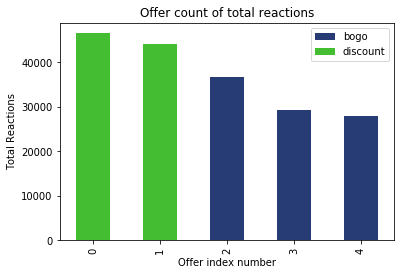

In [215]:

colours = {"bogo": "#273c75", "discount": "#44bd32"}
offer_reactions['Total_reactions'].plot(
        kind="bar", color=offer_reactions['offer_type'].replace(colours)
).legend(
    [
        Patch(facecolor=colours['bogo']),
        Patch(facecolor=colours['discount'])
    ], ["bogo", "discount"]
)
plt.title('Offer count of total reactions')
plt.xlabel('Offer index number')
plt.ylabel('Total Reactions')

From the above chart it is clear that discount is the best performing offer in the dataset

**Develop final recomendation engine that uses model and default recomendations as well**

In [176]:
def make_recommendations(user_id, user_mat, offer_mat):
    reccomendations = {}
    for offer_id in train_matrix.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            reccomendations[offer_id] = pred_val
    if pred_val == None:
        print("Since this user is new, we are reccomending the best performing offer")
        print(offer_reactions.head(1))
    else:
        import operator
        from more_itertools import take
        reccomendations= dict( sorted(reccomendations.items(), key=operator.itemgetter(1),reverse=True))
        top_reccomendation = take(1, reccomendations.items())
        for offer_id, pred_val in top_reccomendation:
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [177]:
#Make best reccomendation for existing user
make_recommendations('0610b486422d4921ae7d2bf64640c50b', user_mat_5, offer_mat_5)

offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  1.41


In [178]:
# Make best reccomendation for new user
make_recommendations('new_user', user_mat_5, offer_mat_5)

Since this user is new, we are reccomending the best performing offer
                           offer_id  Total_reactions
7  fafdcd668e3743c1bb461111dcafc2a4            46510


## 6. Next steps and improvements

In order to improve the above recommendation engine, I would suggest the following approaches.
* The default recommendation for new users can be improved by accounting for demographic information such as gender, age, etc assuming such information is available to us
* Alternatively algorithms apart from Funk SVD or neural networks can be explored

## 7.Credits and references
* Starbucks and Udacity for dataset
* https://stackoverflow.com/questions
* Udacity implementing 'Matrix factorization for Recommendations' lesson for function implementations such as FunkSVD, User item matrix creations, prediction and validation